#TrafficManagementController

##StartTrafficManagement

In [ ]:
// When bots (1 or more) are initialised with certain configuration (botId, initialStationId, etc.)
Start traffic Management;
// Traffic management toggle is a variable that tells if traffic management is running or not.
Set Traffic Management Toggle = TRUE
Initialise all the services
;
while(Traffic Management Toggle is TRUE?)
{
  // By using GetUnresolvedBotPositions in Motor Control Services
  UPDATE unresolved bot positions
  (all unstable bot position info.);
  GET all station information
  (all the status info. of all stations);
  // By using unresolved bot positions and station info. (current station allocation plan)
  UPDATE bot station request
  (which bot is trying to request for which station);
  // By using unresolved bot position and updated bot station requests
  UPDATE station allocation plan
  (how stations are allocated to requesting bots);
  
  // By using unresolved bot position and updated station allocation plan
  UPDATE motor status
  (Trigger motor action/command);
}
STOP
Return "Traffic Management Started";

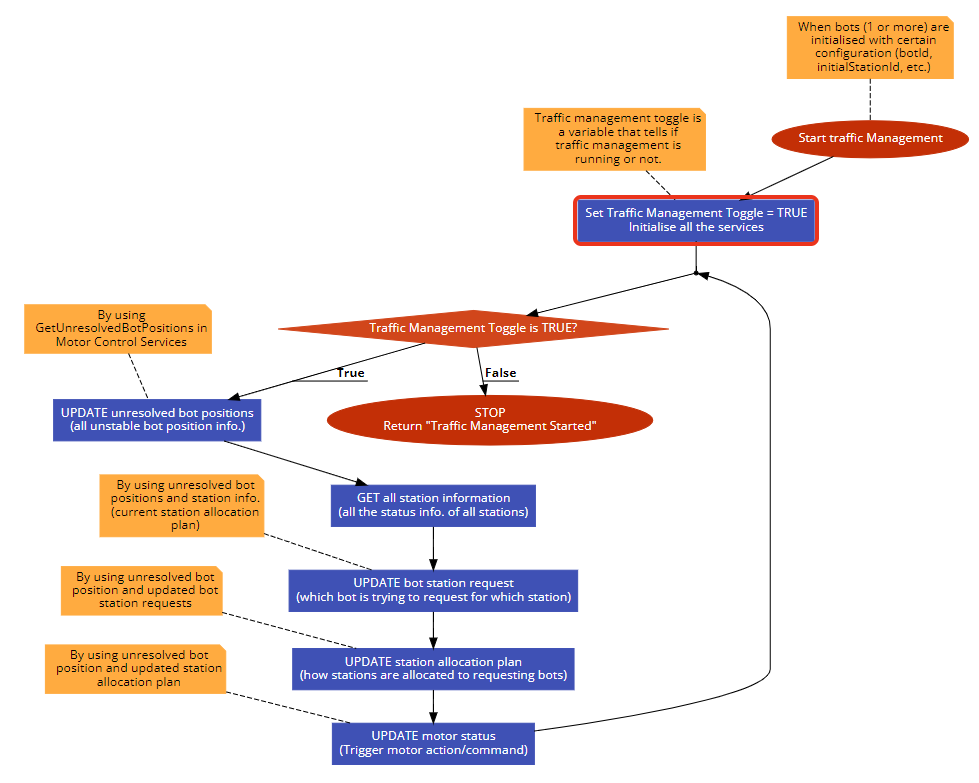

##StopTrafficManagement

In [ ]:
Stop Traffic Management;
Set Traffic Management Toggle = False
;
Return True
"Traffic Management stopped";

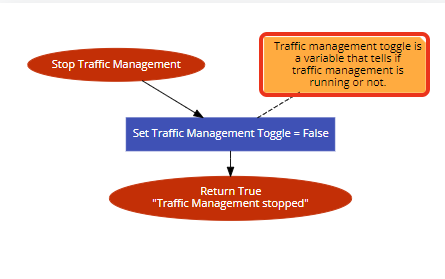

#PathPlanningController

##ReadEdges

In [ ]:
Read Edges;

// Edge information is fetched from a file into a json model called edge-json-model
Return List of all
edges information;

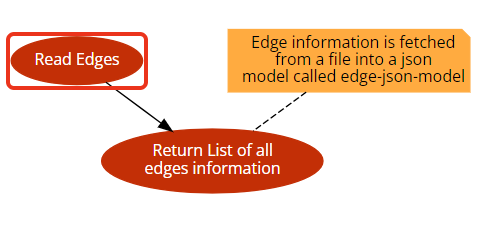

##PlotStations

In [ ]:
Plot Stations;

// Stations are created from the edges information (edge-json-model file) and station information is saved in station-json-model file.
CREATE stations;
Return List of all
stations information;

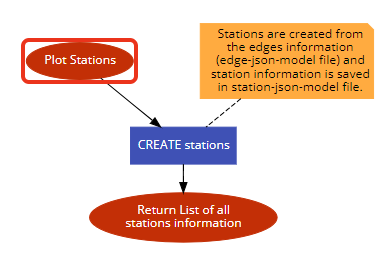